#### Shani Elimelech

#### pipeline for fraud detection from credit card dataset

- load data set
- display class distribution to check data balance
- check features data type
- for categorical features - encode values - if most values are unique leave out the column unless it holds meaning
- throw null values entries or replace with the mean value of the column (depends on the number of null values)
- apply svd to understand data complexity
- apply clustering to see if there is a clear distinction between classes 
- Detect outliers
- for numerical data - compute each feature's variance - if zero variance leave out the column
- check correlations between numerical columns - display groups that are correlated - find a method to choose which feature to keep from each group
- divide the dataset to train,validation,test 
- run a few classification models: XGBoost, logistic regression, SVM
- choose a metric for evaluation
- use val data to choose the best model
- run test data for final prediction
- use shap/ permutations/ greedy algorithm for feature importance


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
import shap
#from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import (
    average_precision_score, precision_recall_curve, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

C:\Users\admin\anaconda3\envs\pecan\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

100%|██████████| 66.0M/66.0M [00:02<00:00, 25.7MB/s]

Extracting files...


Path to dataset files: C:\Users\admin\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


#### load data and observe a small subsample

In [2]:
dataset_df = pd.read_csv('creditcard.csv')
display(dataset_df.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
dataset_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

data type is float64 for all features and there are no null values.
Time column is sequential but not unique 

#### check class distribution


number of positives: 492
number of negatives: 284315


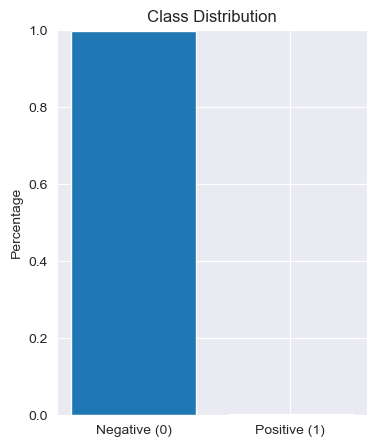

In [19]:
num_rows = dataset_df.shape[0]
positive_num = dataset_df[dataset_df['Class'] == 1].shape[0] 
negative_num = dataset_df[dataset_df['Class'] == 0].shape[0] 

print(f'number of positives: {positive_num}'
      f'\nnumber of negatives: {negative_num}')
# Bar plot
plt.figure(figsize=(4,5))
plt.bar(['Negative (0)', 'Positive (1)'], [negative_num / num_rows, positive_num / num_rows])
plt.ylabel('Percentage')
plt.title('Class Distribution')
plt.ylim(0, 1)
plt.show()

as expected the data is highly unbalanced - the number of positive samples is significantly smaller than negative samples and in order to train a robust and unbiased predictive model resampling the data should be considered.

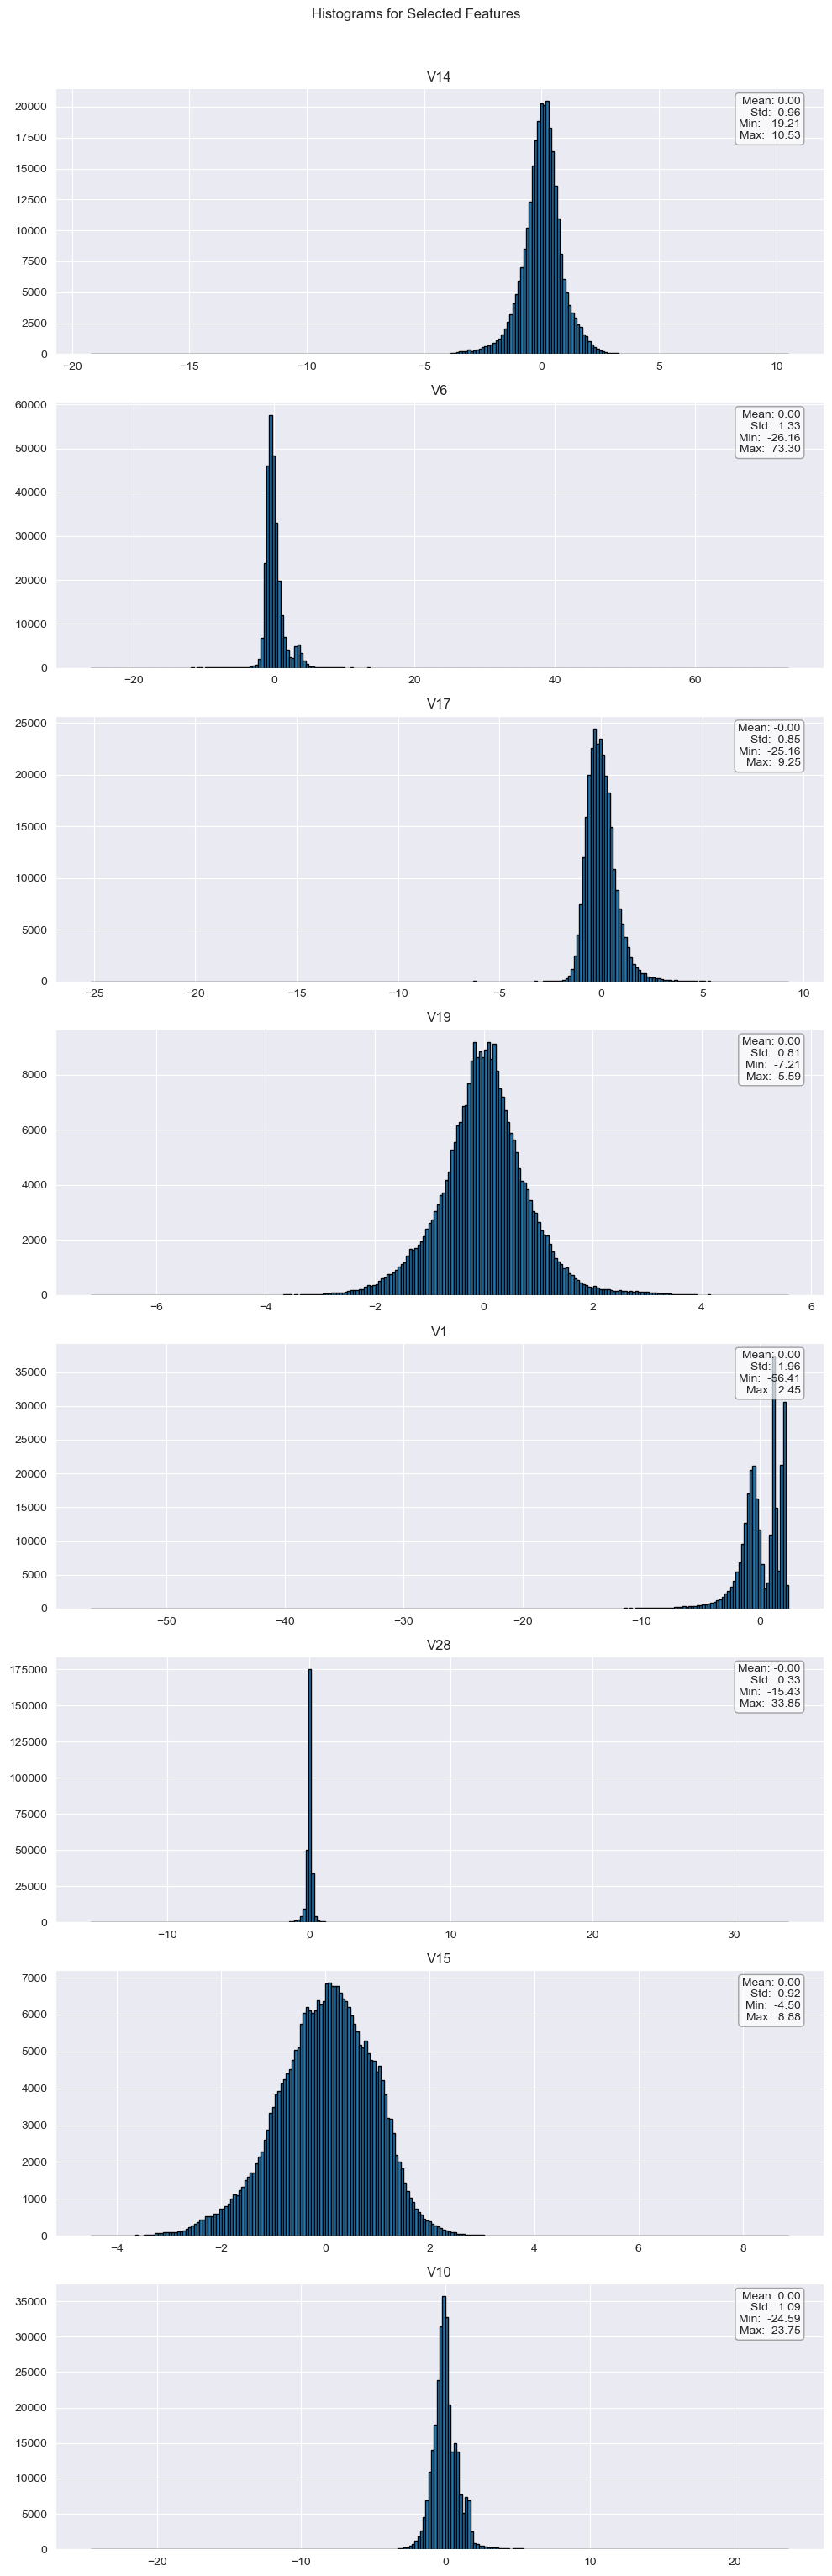

In [53]:
# plotting histograms for randomly selected features
features_df = dataset_df.iloc[:,:-1]
columns = np.random.choice(features_df.columns.tolist(), 8)
selected_columns = dataset_df[columns]
fig, axes = plt.subplots(nrows=8, ncols=1, figsize=(10, 30)) 
axes = axes.flatten()  
for i, column in enumerate(selected_columns.columns):
    data = selected_columns[column].dropna()
    # compute stats
    mean_val = data.mean()
    std_val = data.std()
    min_val = data.min()
    max_val = data.max()

    # plot histogram
    axes[i].hist(data, bins=250, edgecolor='black')
    axes[i].set_title(column)
    # formatted stats text
    stats_text = (
        f"Mean: {mean_val:.2f}\n"
        f"Std:  {std_val:.2f}\n"
        f"Min:  {min_val:.2f}\n"
        f"Max:  {max_val:.2f}"
    )
    # add text box inside axes
    axes[i].text(
        0.97, 0.97, stats_text,
        transform=axes[i].transAxes,
        fontsize=10,
        verticalalignment='top',
        horizontalalignment='right',
        bbox=dict(boxstyle="round", fc="white", ec="gray", alpha=0.7)
    )
plt.tight_layout()
plt.suptitle('Histograms for Selected Features', y=1.02)
plt.show()

looks like most features are normally distributed around zero and some display strong outliers (which could be the rare positive class).

#### apply svd 
extracting most dominant dimensions from the data set will help us understand how complex it is.
extracting latent dimensions that could be the distinctive dimensions between classes. 
its an indication for how strongly the data is correlated.
also, we can explore which features hold most variance.

In [3]:
def svd(df):
    Y = np.array(df).astype(float)
    # standardize features
    Y = np.divide(Y - np.mean(Y, axis=0, keepdims=True), np.std(Y, axis=0, keepdims=True))  
    U, S, VT = np.linalg.svd(Y)
    var_explained = S**2 / sum(S**2)
    return U, S, VT, var_explained


def plot_svd(var_explained):
    # plot cumulative variance explained 
    cumm = var_explained.cumsum()
    n_min = np.argmax(cumm >= 0.9)
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(var_explained) + 1), cumm)
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance Explained')
    plt.title('Cumulative Variance Explained by Principal Components')
    plt.axhline(y=0.9, color='b', linestyle='--', label='90% of variance')
    plt.axvline(x=n_min+1, color='g', linestyle='--', label='number of components to reach 90% of variance')
    plt.grid()
    plt.legend(loc='best')
    plt.show()
    
    # plot variance explained 
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(1, len(var_explained) + 1), var_explained)
    plt.xlabel('Principal Components')
    plt.ylabel('Variance Explained')
    plt.title('Variance Explained of Principal Components')
    plt.grid()
    plt.show()

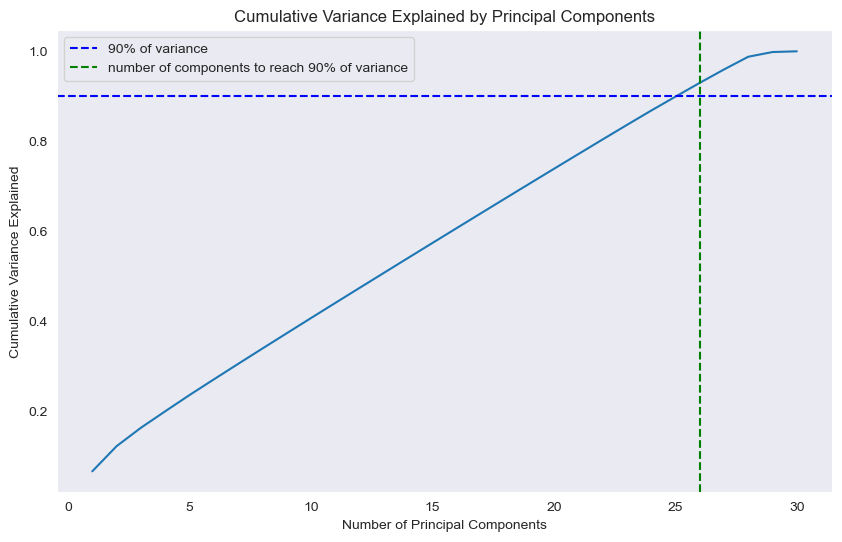

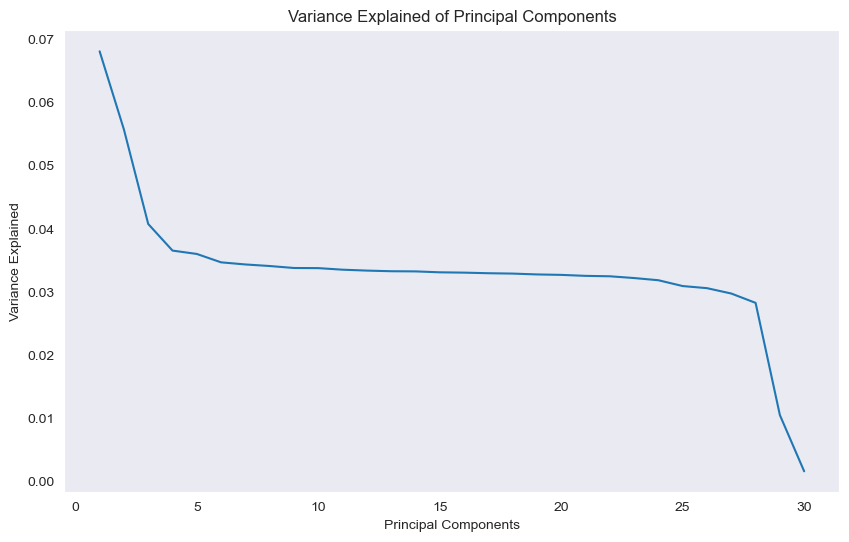

In [4]:
# take a random subsample of rows and keep class distribution

X_sample, _, y_sample, _ = train_test_split(
                dataset_df.iloc[:,:-1], dataset_df.iloc[:,-1],
                train_size=0.2,
                stratify=dataset_df.iloc[:,-1],
                random_state=42
            )
U, S, VT, ve = svd(X_sample)   
plot_svd(ve)

it looks like variance explained grows linearly with number of added components which could indicate that each component is equally important, that pattern is clearly presented in the second plot where there is a plateau. even with 20% of the samples data looks very complex

#### feature engineering and feature selecting
1. if features display zero variance - throw out as they wont contribute to classes separation
2. Detect outliers and remove them only if they are negative instances
3. compute correlation matrix to remove highly correlated groups of features using a set threshold

In [10]:
features = dataset_df.iloc[:,:-1]
classes = dataset_df.iloc[:,-1]
len(features)

284807

In [11]:
# compute standard deviations
std_vals = features.std()
std_threshold = 1e-4    # threshold
near_zero_var_features = std_vals[std_vals <= std_threshold].index.tolist()
print("Near-zero variance features removed:", near_zero_var_features)

X_clean = features.drop(columns=near_zero_var_features)

Near-zero variance features removed: []


In [12]:
# detect outliers per feature
Q1 = X_clean.quantile(0.25)
Q3 = X_clean.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = (X_clean < (Q1 - 1.5 * IQR)) | (X_clean > (Q3 + 1.5 * IQR))

# count outlier cells per row
outlier_counts = outlier_mask.sum(axis=1)

outlier_df = pd.DataFrame({
    'outlier_count': outlier_counts,
    'label': classes.values
})

# outliers counts for two classes
outliers_positive = outlier_df[outlier_df['label'] == 1]['outlier_count'].gt(0).sum()
outliers_negative = outlier_df[outlier_df['label'] == 0]['outlier_count'].gt(0).sum()

print("Outliers belonging to POSITIVE class:", outliers_positive)
print("Outliers belonging to NEGATIVE class:", outliers_negative)

Outliers belonging to POSITIVE class: 477
Outliers belonging to NEGATIVE class: 137996


In [13]:
# rows considered outliers (any feature flagged)
rows_with_outliers = outlier_df['outlier_count'] > 0

# remove only if label == 0 (negative)
rows_to_remove = rows_with_outliers & (outlier_df['label'] == 0)

print("Rows removed (negative outliers only):", rows_to_remove.sum())

X_final = X_clean.loc[~rows_to_remove].copy()
y_final = classes.loc[~rows_to_remove].copy()

print("Final dataset shape:", X_final.shape)
print("Final label distribution:\n", y_final.value_counts())

Rows removed (negative outliers only): 137996
Final dataset shape: (146811, 30)
Final label distribution:
 Class
0    146319
1       492
Name: count, dtype: int64


<Axes: >

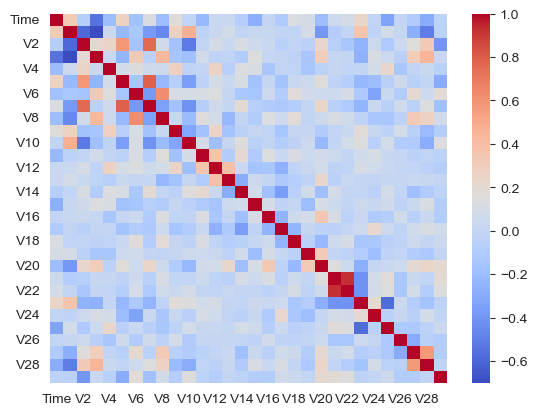

In [14]:
# analyze the correlation between features

corr_matrix = X_final.corr(method='spearman')    #method='spearman'
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')

There are 1 features that are highly correlated to other features in the data
['V22']


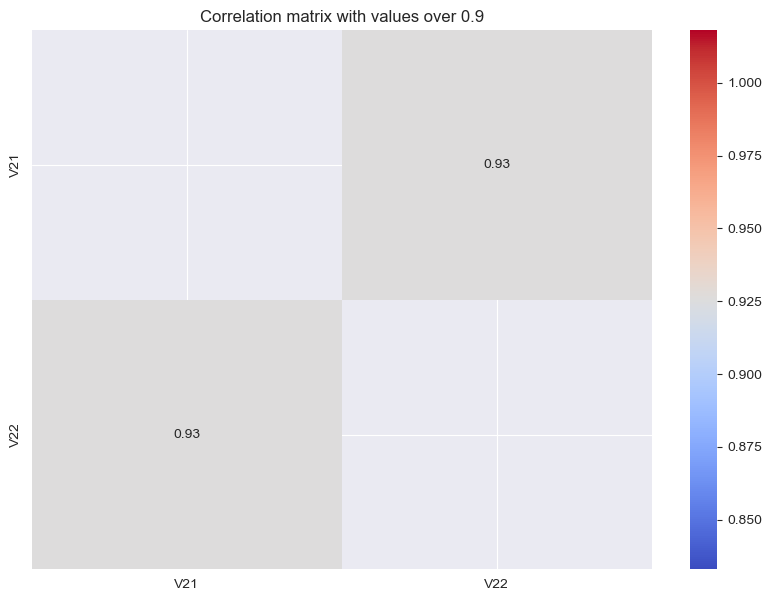

In [15]:
threshold = 0.9  # setting a high threshold - only features that are highly correlated will be removed
mask = (corr_matrix > threshold) & (corr_matrix != 1.0)
filtered_corr_matrix = corr_matrix[mask].dropna(axis=0,how='all').dropna(axis=1,how='all')
columns = []
values = []
for i, row in filtered_corr_matrix.iterrows():
    for column, value in row.items():
        if pd.notna(value) and value not in values and column not in columns:
            columns.append(column)
            values.append(value)
        
print(f'There are {len(columns)} features that are highly correlated to other features in the data')
print(columns)
if not filtered_corr_matrix.isna().all().all():
    plt.figure(figsize=(10, 7))
    sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm')
    plt.title('Correlation matrix with values over 0.9')
    plt.show()
else:
    print("No correlations above the threshold.")
    
# removing the correlated features from the data
X_final.drop(columns=columns, inplace=True)

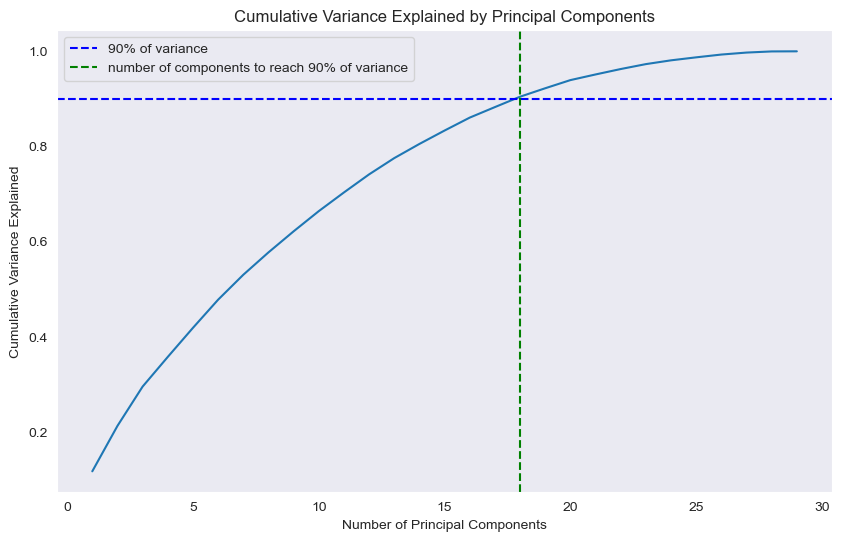

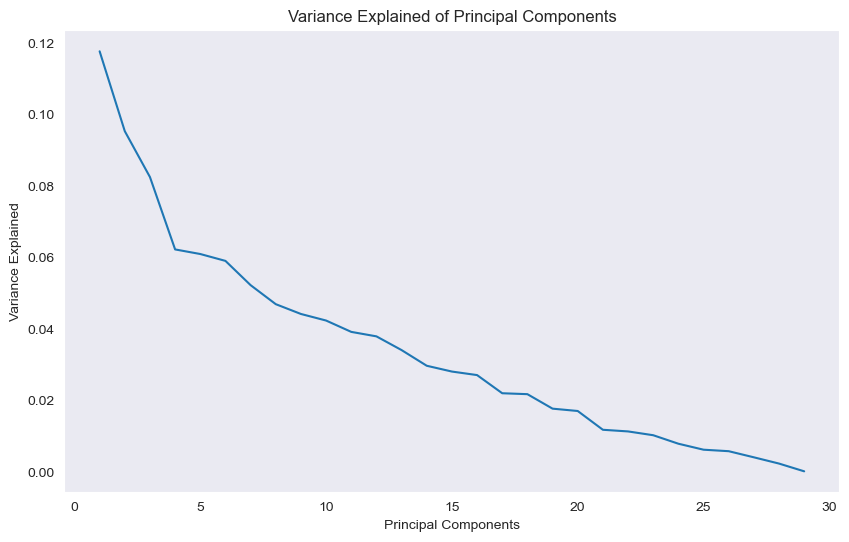

In [11]:
# after filtering outliers - run svd again 

X_sample, _, y_sample, _ = train_test_split(
                X_final, y_final,
                train_size=0.2,
                stratify=y_final,
                random_state=42
            )
U, S, VT, ve = svd(X_sample) 
plot_svd(ve)

#### apply clustering
check if only the first two latent variables are enough to separate the classes

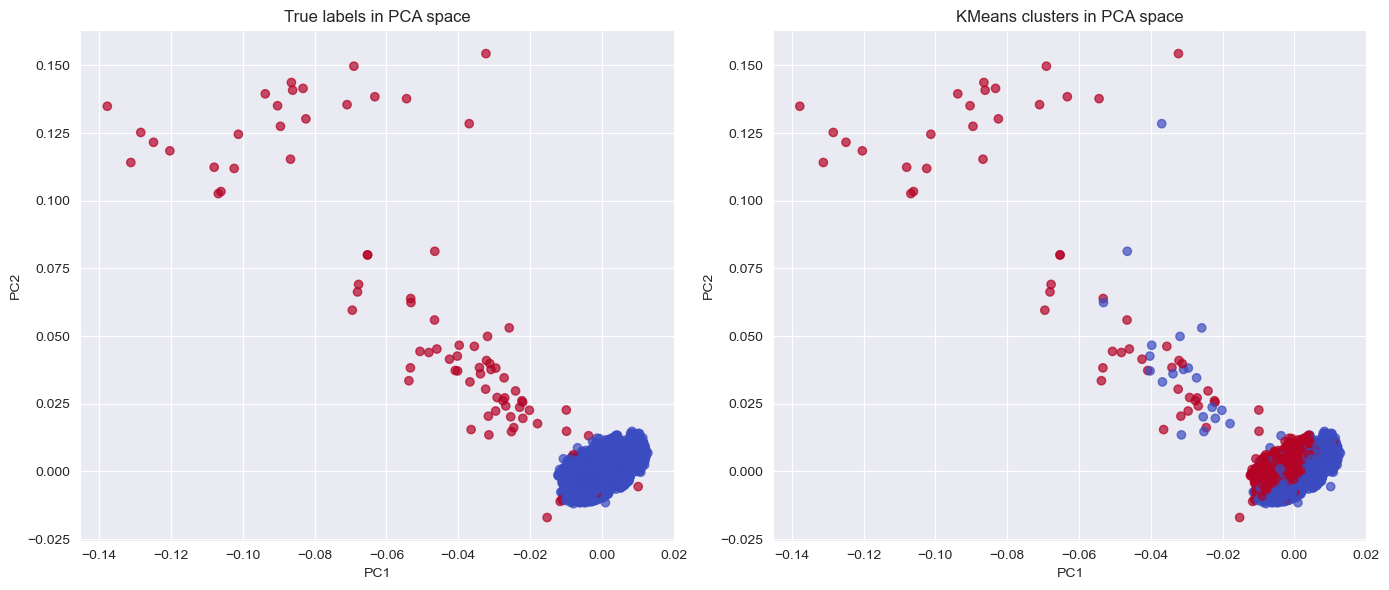

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(X_sample)

# 3) Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot true labels
scatter1 = axes[0].scatter(U[:, 0], U[:, 1], 
                           c=y_sample, cmap='coolwarm', alpha=0.7)
axes[0].set_title("True labels in PCA space")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Plot cluster assignments
scatter2 = axes[1].scatter(U[:, 0], U[:, 1],
                           c=cluster_labels, cmap='coolwarm', alpha=0.7)
axes[1].set_title("KMeans clusters in PCA space")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
plt.tight_layout()
plt.show()

#### build predictive models for classification task 
compare between three different models and choose the one with the best performance

In [16]:
# classifier wrapper 
class Classifier:
    def __init__(
        self,
        model,
        params=None,
        grid_params=None,
        use_scaler=False,
        model_name=None,
        use_sampling=False, 
        sampler=None
    ):
        """
        model: can be a model class (e.g., LogisticRegression) or an *instance*
        params: kwargs for model if model is a class
        grid_params: dict for GridSearchCV
        use_scaler: if True -> wrap in Pipeline(StandardScaler + model)
        """

        self.grid_params = grid_params
        self.best_model = None
        self.model_name = model_name
        self.params = params if params else {}
        classifier = model(**self.params)
        if model_name is None:
            self.model_name = model.__name__

        steps = []
        if use_scaler:
            steps.append(("scaler", RobustScaler()))

        if use_sampling:
            if sampler is None:
                sampler = RandomUnderSampler(sampling_strategy=0.02)
            steps.append(("sampler", sampler))

        steps.append(("clf", classifier))
        self.model = Pipeline(steps)


    def train(self, X, y, X_val=None, y_val=None, early_stopping=False, es_rounds=20):
        """
        Train model. For XGBoost, supports early stopping if X_val, y_val are given.
        """
        if isinstance(self.model, XGBClassifier) and early_stopping and X_val is not None and y_val is not None:
            self.model.fit(
                X, y,
                eval_set=[(X_val, y_val)],
                early_stopping_rounds=es_rounds,
                verbose=False
            )
        else:
            # no early stopping
            self.model.fit(X, y)


    def predict(self, X):
        return self.model.predict(X)


    def predict_proba(self, X):
        """
        Returns probability for positive class (1) for binary classification.
        """
        return self.model.predict_proba(X)[:, 1]
  
  
    def evaluate(self, X, y):
        """
        Returns a dict of metrics for evaluation
        """
        y_pred = self.predict(X)
        y_proba = self.predict_proba(X)

        return {
            "recall":    recall_score(y, y_pred),
            "precision": precision_score(y, y_pred),
            "f1":        f1_score(y, y_pred),
            "pr_auc":    average_precision_score(y, y_proba)
        }


    # ---------- Cross-validation & Grid Search ----------

    def stratified_cv(self, X, y, cv=5, scoring=None):
        """
        Stratified cross validation with leakage safe scaling (model is a Pipeline that contains scaling)
        keep class distribution within each fold.
        scoring: dict or string; if None, a standard set is used.
        """
        if scoring is None:
            scoring = {
                "recall": "recall",
                "f1": "f1",
                "pr_auc": "average_precision"
            }

        skf = StratifiedKFold(
            n_splits=cv,
            shuffle=True,
            random_state=42
        )

        cv_results = cross_validate(
            self.model,
            X,
            y,
            cv=skf,
            scoring=scoring,
            return_train_score=False
        )

        # compute the average results over all folds
        ave_cv_results = {k: np.mean(v) for k, v in cv_results.items() if k.startswith("test_")}
        return ave_cv_results


    def grid_search(self, X, y, scoring="average_precision", cv=5):
        """
        GridSearchCV with StratifiedKFold.
        """
        if not self.grid_params:
            raise ValueError("grid_params not provided for grid search.")

        skf = StratifiedKFold(
            n_splits=cv,
            shuffle=True,
            random_state=42
        )

        gs = GridSearchCV(
            estimator=self.model,
            param_grid=self.grid_params,
            scoring=scoring,
            cv=skf,
            n_jobs=-1,
            refit=True
        )

        gs.fit(X, y)
        self.best_model = gs.best_estimator_
        self.model = self.best_model  # replace with best performed model

        return gs.best_params_, gs.best_score_


    def get_params(self):
        return self.model.get_params()


    # ---------- Feature importance ----------

    def _get_inner_estimator(self):
        """
        If model is a Pipeline, return final estimator, else return model.
        """
        if isinstance(self.model, Pipeline):
            return self.model.named_steps["clf"]
        return self.model


    def feature_importance(
        self,
        X=None,
        y=None,
        feature_names=None,
        top_n=None,
        n_repeats=10,
        random_state=42
    ):
        """
        Compute feature importance:
        - If model is XGBoost -> SHAP TreeExplainer
        - Otherwise -> permutation importance (model agnostic)
    
        X, y are required for both SHAP and permutation.
        """
    
        if X is None or y is None:
            raise ValueError("X and y must be provided for feature importance.")
    
        # Retrieve underlying estimator
        est = self._get_inner_estimator()
    
        # XGBoost - use SHAP
        if est.__class__.__name__ == "XGBClassifier":
            booster = est.get_booster()
            explainer = shap.TreeExplainer(booster)
            
            # Sample if dataset is very large (optional)
            X_sample, _, y_sample, _ = train_test_split(
                X, y,
                train_size=0.3,
                stratify=y,
                random_state=42
            )
    
            shap_values = explainer.shap_values(X_sample)
    
            # SHAP returns array shaped (n_samples, n_features)
            importances = np.abs(shap_values).mean(axis=0)
    
        # Other model types - permutation importance
        else:
            result = permutation_importance(
                self.model,
                X,
                y,
                n_repeats=n_repeats,
                random_state=random_state,
                n_jobs=-1
            )
            importances = result.importances_mean
    
        n_features = len(importances)
        if feature_names is None:
            feature_names = [f"feature_{i}" for i in range(n_features)]
    
        feats = list(zip(feature_names, importances))
        feats.sort(key=lambda x: x[1], reverse=True)
    
        if top_n is not None:
            feats = feats[:top_n]
    
        return feats
    
    
    def forward_feature_selection(self, X, y, scoring="average_precision", cv=5, max_features=None, sample_frac=1.0):
        """
        Greedy forward feature selection. good for dimensionality reduction.
        X: pandas DataFrame
        y: array-like
        scoring: metric for cross_val_score
        cv: number of folds (StratifiedKFold)
        max_features: stop after selecting this many features (None = use all)
        sample_frac: optional fraction of rows to speed up selection 
        """
        # Optional subsampling to speed computation (dataset size is ~280k rows)
        if sample_frac < 1.0:
            X_sample, _, y_sample, _ = train_test_split(
                X, y,
                train_size=sample_frac,
                stratify=y,
                random_state=42
            )
        else:
            X_sample = X
            y_sample = y
    
        feature_names = list(X_sample.columns)
        selected = []
        remaining = feature_names.copy()
        history = []  # list of cv_score
    
        skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
        while remaining and (max_features is None or len(selected) < max_features):

            from joblib import Parallel, delayed
            def eval_feature(feat, selected, X_sample, y_sample, scoring, skf, model):
                current_feats = selected + [feat]
                X_subset = X_sample[current_feats]


                scores = cross_val_score(
                    model,
                    X_subset,
                    y_sample,
                    scoring=scoring,
                    cv=skf,
                    n_jobs=1
                )
                mean_score = scores.mean()

                return feat, mean_score

            results = Parallel(n_jobs=-1)(
                            delayed(eval_feature)(feat, selected, X_sample, y_sample, scoring, skf, self.model)
                            for feat in remaining)

            feats, scores = zip(*results)
            best_idx = int(np.argmax(scores))
            best_feat = feats[best_idx]
            best_score = scores[best_idx]
            print(f'Best feature: {best_feat}, score: {best_score}')
            selected.append(best_feat)
            remaining.remove(best_feat)
            history.append(best_score)
    
        return selected, history


    # ---------- save and load model ----------

    def save(self, filepath):
        """
        Save the current model (including pipeline, best params, etc.).
        """
        joblib.dump(self.model, filepath)


    @classmethod
    def load(cls, filepath):
        """
        Load a saved model from memory and create Classifier object
        """
        loaded_model = joblib.load(filepath)
        obj = cls.__new__(cls)          # create instance without calling __init__
        obj.model = loaded_model        # assign saved pipeline
        return obj


    # ---------- plot results ----------

    def plot_confusion_matrix(self, X, y, normalize=False, labels=None):
        """
        Plot confusion matrix.
        normalize: if True, shows percentages per row.
        """
        y_pred = self.predict(X)
        cm = confusion_matrix(y, y_pred, labels=labels)
        if normalize:
            cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

        fig, ax = plt.subplots()
        im = ax.imshow(cm)
        ax.figure.colorbar(im, ax=ax)
        classes = labels if labels is not None else np.unique(y)
        ax.set(
            xticks=np.arange(len(classes)),
            yticks=np.arange(len(classes)),
            xticklabels=classes,
            yticklabels=classes,
            ylabel="True label",
            xlabel="Predicted label",
            # title=f"Confusion Matrix - {self.model_name}"
            title=f"Confusion Matrix - SVM"
        )
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        fmt = ".2f" if normalize else "d"
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(
                    j, i,
                    format(cm[i, j], fmt),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] < thresh else "black"
                )
        plt.tight_layout()
        plt.show()

In [17]:
def plot_pr_curves(models, X, y):
    """
    Plot Precision–Recall curves for multiple trained models.

    models : dict {model_name: Classifier_instance}
    X, y  : evaluation data (val or test set)
    """
    plt.figure(figsize=(8, 6))

    for name, clf in models.items():
        # get prediction probabilities
        y_proba = clf.predict_proba(X)

        # compute PR curve
        precision, recall, _ = precision_recall_curve(y, y_proba)

        # compute Average Precision (PR-AUC)
        pr_auc = average_precision_score(y, y_proba)

        # plot curve
        plt.plot(recall, precision, label=f"{name} (PR-AUC = {pr_auc:.6f})")

    # baseline: prevalence of positive class
    baseline = y.mean()
    plt.hlines(baseline, 0, 1, colors="gray", linestyles="--",
               label=f"Baseline ({baseline:.6f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves Comparison")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
def plot_feature_importance(fi, model_name):
    # unpack names and values
    names = [f[0] for f in fi]
    scores = [f[1] for f in fi]

    plt.figure(figsize=(8, 5))
    plt.barh(names, scores)
    plt.gca().invert_yaxis()  # highest at top
    plt.xlabel("Importance Score")
    plt.title(f"Top Feature Importances - {model_name}")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Define models

In [19]:
# ---- Define models ----
logreg_clf = Classifier(
    model=LogisticRegression,
    params={'max_iter': 1000, 'class_weight':"balanced", 'penalty':'l2'},
    grid_params={
        'clf__C': [0.1, 1, 10]  # note 'clf__' because of Pipeline when use_scaler=True
    },
    use_scaler=True,
    model_name='Logistic Regression'
)

svm_clf = Classifier(
    model=SVC,
    params={'probability': True, 'class_weight':"balanced"},
    grid_params={
        'clf__C': [0.1, 1, 10],
        'clf__kernel': ['linear', 'rbf']
    },
    use_scaler=True,
    model_name='SVM'
)

xgb_clf = Classifier(
    model=XGBClassifier,
    params={
        'eval_metric': 'logloss',
        'scale_pos_weight': 576
    },
    grid_params={
        'clf__n_estimators': [100, 200],
        'clf__learning_rate': [0.01, 0.05, 0.1],
        'clf__max_depth': [3, 4, 5]
    },
    use_scaler=False,  # trees don't need standardization
    model_name='XGBoost'
)

models = {
    'logreg': logreg_clf,
    'svm': svm_clf,
    'xgb': xgb_clf
}


#### Compare models

In [63]:
# testing a small subset
X, _, y, _ = train_test_split(
    X_final, y_final,
    train_size=0.3,        
    stratify=y_final,
    random_state=42
)

logreg best params: {'clf__C': 0.1} PR AUC: 0.9283782357124227
logreg {'recall': 0.9489795918367347, 'precision': 0.181640625, 'f1': 0.30491803278688523, 'pr_auc': 0.9329127128791571}
svm best params: {'clf__C': 10, 'clf__kernel': 'linear'} PR AUC: 0.9324858687781233
svm {'recall': 0.9693877551020408, 'precision': 0.2486910994764398, 'f1': 0.3958333333333333, 'pr_auc': 0.9444329981165084}


C:\Users\admin\anaconda3\envs\pecan\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


xgb best params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100} PR AUC: nan
xgb {'recall': 0.9387755102040817, 'precision': 0.1713221601489758, 'f1': 0.28976377952755905, 'pr_auc': 0.8303936998544296}


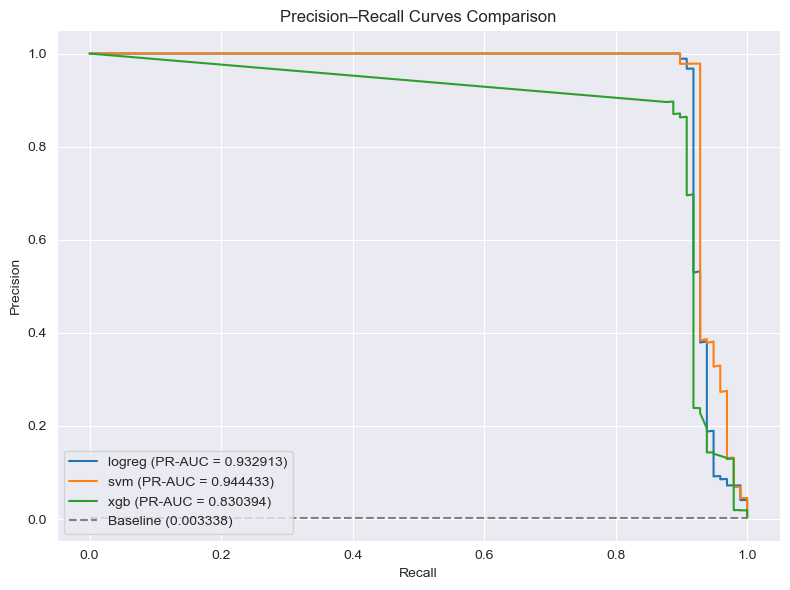

In [15]:
results = {}

# split data to train,va,test while preserving class distribution
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,          # 20% test
    stratify=y_final,
    random_state=42
)

# Step 2 — split remaining into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.25,         # 20% validation
    stratify=y_train_full,
    random_state=42
)

for name, clf in models.items():
    # grid search with stratified CV on train set
    best_params, best_score = clf.grid_search(X_train, y_train, scoring="average_precision", cv=5)
    print(name, "best params:", best_params, "PR AUC:", best_score)

    # Evaluate on validation set
    metrics = clf.evaluate(X_val, y_val)
    results[name] = metrics
    print(name, metrics)

plot_pr_curves(models, X_val, y_val)

In [16]:
# Choose best by F1 on validation
best_name = max(results, key=lambda k: results[k]["pr_auc"])
best_clf = models[best_name]
print("Best model:", best_name, results[best_name])

# Retrain on train+val with early stopping if XGBoost
if isinstance(best_clf.model, XGBClassifier):
    # Create small internal validation split for early stopping
    X_tr, X_es, y_tr, y_es = train_test_split(
        X_train_full, y_train_full,
        test_size=0.2,
        stratify=y_train_full,
        random_state=42
    )
    best_clf.train(X_tr, y_tr, X_val=X_es, y_val=y_es, early_stopping=True, es_rounds=20)
else:
    best_clf.train(X_train_full, y_train_full)

# Final evaluation on test set
final_metrics = best_clf.evaluate(X_test, y_test)
print("Final test metrics:", final_metrics)

# Save final model
best_clf.save(f"best_model {best_name}.joblib")

Best model: svm {'recall': 0.9693877551020408, 'precision': 0.2486910994764398, 'f1': 0.3958333333333333, 'pr_auc': 0.9444329981165084}
Final test metrics: {'recall': 0.9693877551020408, 'precision': 0.19791666666666666, 'f1': 0.328719723183391, 'pr_auc': 0.9507628315932958}


In [20]:
best_clf = Classifier.load(f'best_model SVM.joblib')
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_final, y_final,
    test_size=0.2,          # 20% test
    stratify=y_final,
    random_state=42
)

# Step 2 — split remaining into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=0.25,         # 20% validation
    stratify=y_train_full,
    random_state=42
)


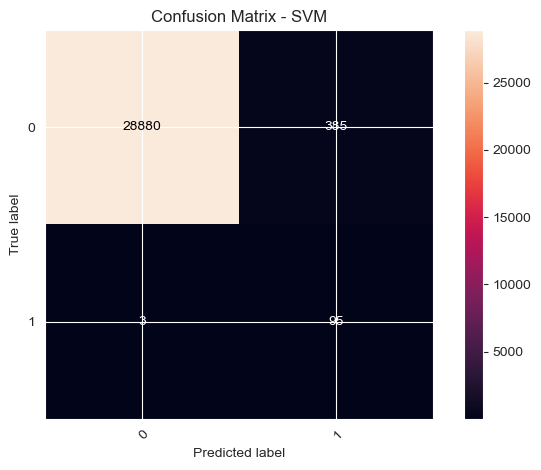

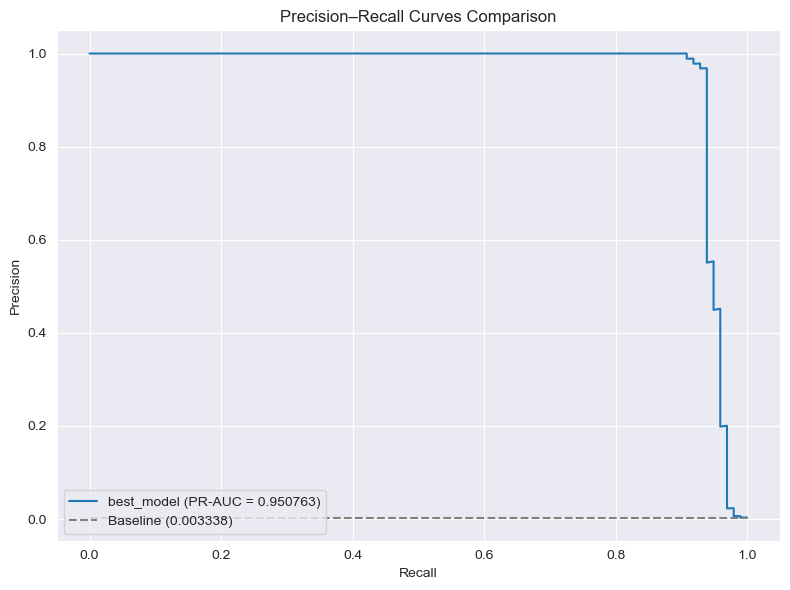

In [21]:
# plot confusion matrix & PR curve on test set
best_clf.plot_confusion_matrix(X_test, y_test, normalize=False)
plot_pr_curves({"best_model": best_clf}, X_test, y_test)

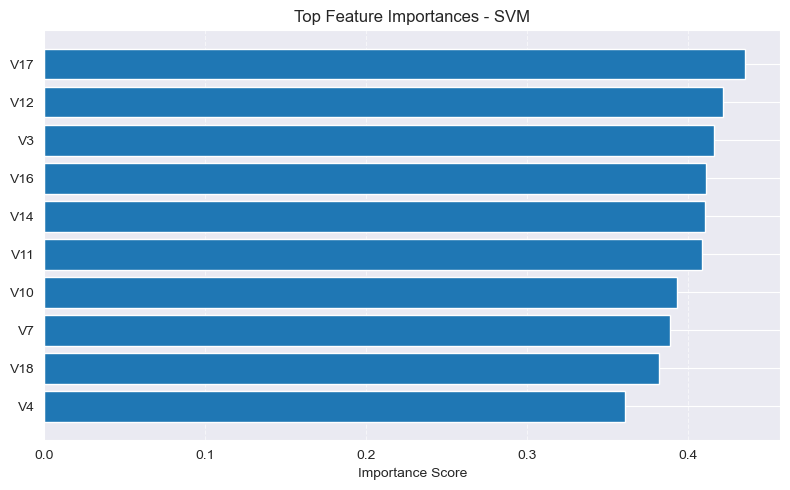

In [18]:
# feature importance
feature_names = X_train_full.columns.tolist()
fi = best_clf.feature_importance(
    X=X_train_full,
    y=y_train_full,
    feature_names=feature_names,  # list of column names
    top_n=10,
)
plot_feature_importance(fi, best_clf.model_name)

#### feature importance analysis - greedy forward selection
there are only 28 features so there is no critical need for greedy feature selection (dimensionality reduction) as it is computational expansive and also ignores feature interaction (it evaluates features in sequence not combinations), but it's nice for global ranking and to see performance improvement when adding more features.

In [ ]:
best_features, score_history = best_clf.forward_feature_selection(
    X_train,  
    y_train,
    scoring="average_precision",
    cv=5,
    max_features=None,    
    sample_frac=0.8
)

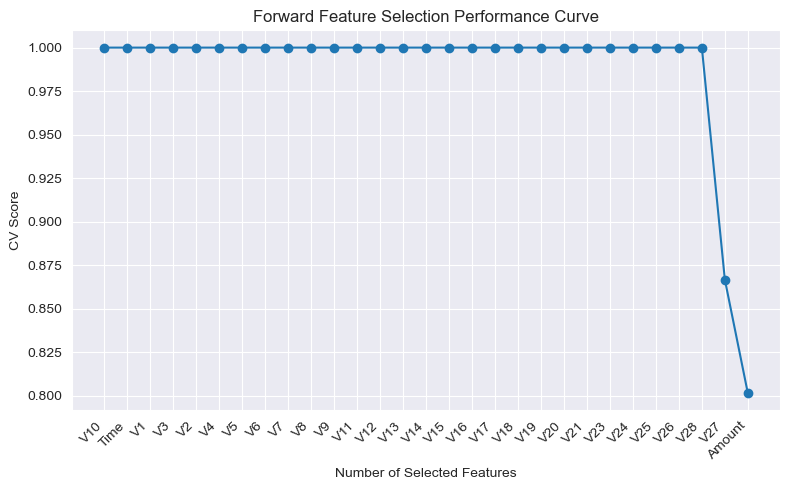

In [20]:
plt.figure(figsize=(8,5))
x = range(1, len(score_history) + 1)
plt.plot(x, score_history, marker="o")
plt.xticks(x, best_features, rotation=45, ha="right")
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Forward Feature Selection Performance Curve")
plt.grid(True)
plt.tight_layout()
plt.show()